## Dependencies 

In [35]:
import os 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cv2
import random
from scipy import ndimage
from tqdm  import tqdm

## Extract and Label data

In [28]:
def get_labels() -> list[dict]:
    furniture_path = './Furniture_Data'
    labels =  []
    for root, _, files in os.walk(furniture_path):
        for file in files:
            if file.endswith('.jpg'):
                
                path = os.path.join(root, file)
                dirs = path.split(os.path.sep)

                furniture = dirs[2][:-1] #Remove trailing `s` 
                style = dirs[3].lower() #lowercase

                label = {
                    'path': path,
                    'furniture': furniture,
                    'style': style
                }

                labels.append(label)

    return labels

labels = get_labels()
df = pd.DataFrame(labels)

In [5]:
df.head()

,path,furniture,style
0,./Furniture_Data/tables/Eclectic/4029eclectic-...,table,eclectic
1,./Furniture_Data/tables/Eclectic/4107eclectic-...,table,eclectic
2,./Furniture_Data/tables/Eclectic/3885eclectic-...,table,eclectic
3,./Furniture_Data/tables/Eclectic/4040eclectic-...,table,eclectic
4,./Furniture_Data/tables/Eclectic/4171eclectic-...,table,eclectic


## EDA 

The dataset sample isn't distributed evenly across all furniture

furniture
lamp       32401
chair      22053
table      17100
dresser     7870
bed         6578
sofa        4080
Name: count, dtype: int64

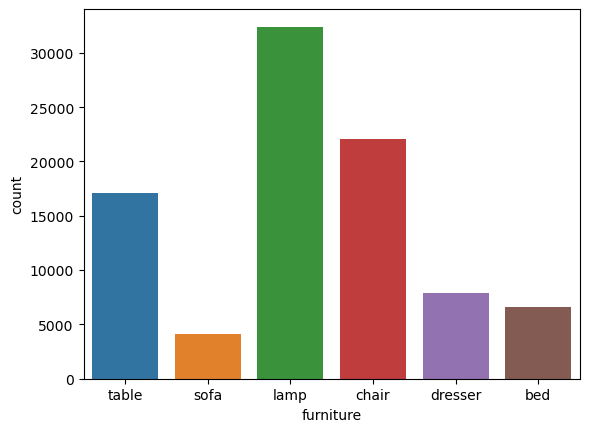

In [6]:
sns.countplot(data=df, x="furniture")

df['furniture'].value_counts()

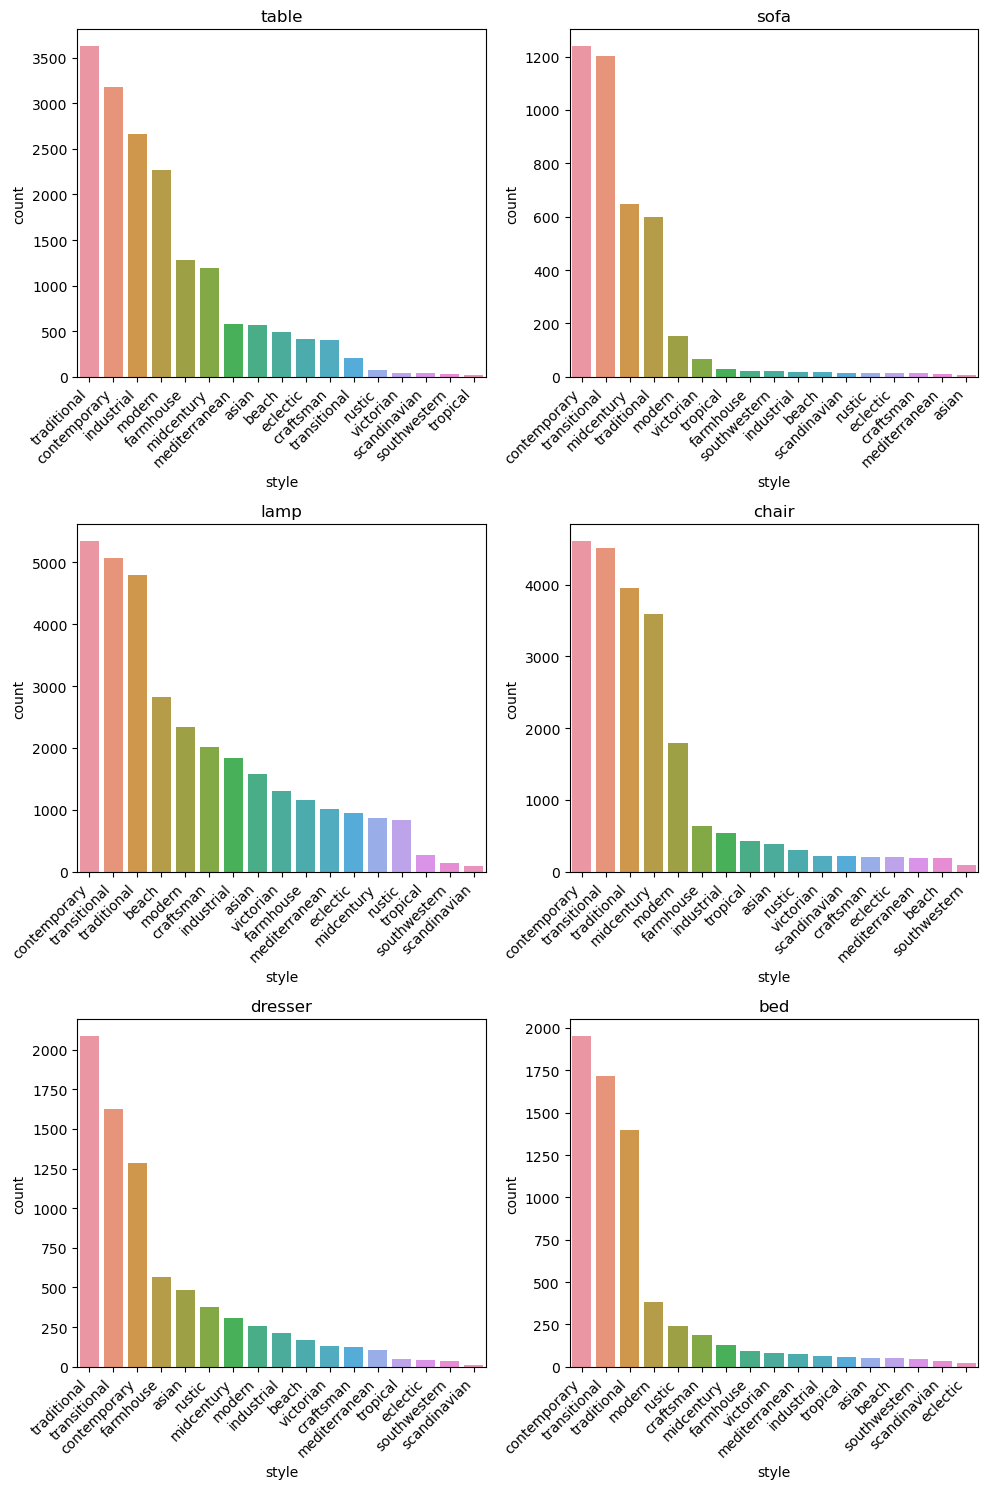

In [7]:
# Get unique furniture types
furniture_types = df['furniture'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharex=False)

# Plot each furniture type
for i, furniture_type in enumerate(furniture_types):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    data = df[df['furniture'] == furniture_type]
    sns.countplot(x='style', data=data, order=data['style'].value_counts().index, ax=ax)
    ax.set_title(furniture_type)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Show x-axis tick labels for each subplot
    ax.tick_params(axis='x', which='both', bottom=True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Data Augmentation

Try to apply following data augmentation techniques 
- Flip
- Rotate
- Histogram Equalization

In [4]:
# Function for histogram equalization
def hist_equal(img):
    img_to_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_to_yuv[:, :, 0] = cv2.equalizeHist(img_to_yuv[:, :, 0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_equalization_result

# Function for image zooming
def zoom_image(image, scale, center):
    
    height, width = image.shape[:2]
    new_height = int(height * scale)
    new_width = int(width * scale)

    zoomed_image = cv2.resize(image, (new_width, new_height))
    x = int(center[0] - width / 2)
    y = int(center[1] - width / 2)
    roi = zoomed_image[y : y + height, x : x + width]

    return roi

# Function for image augmentation
def image_augmentation(image):
    flip_h = cv2.flip(image, 0) # Flip image horizontally

    # Get image dimensions
    height, width = flip_h.shape[:2]

    # Define the zoom factor (e.g., zooming in by a factor of 1.5)
    zoom_factor = 1.5

    # Calculate the new dimensions after zooming
    new_height = int(height * zoom_factor)
    new_width = int(width * zoom_factor)

    zoomed_image = cv2.resize(image, (new_width, new_height))
    histogram = hist_equal(image)
    adjusted = cv2.convertScaleAbs(histogram, alpha = 1.0, beta = 5) # Adjust image's contrast and brightness

    return adjusted

**Resampling Problem Brainstorming**
- Flowers: Only have 1 layer of category. Can easily resample by just calculating the difference between each category with the category max amount
   - Technique: Transform the curr scanned image until the current number of category matches the maximum amount
- Furniture: Have 2 layers of categories
  - Naive resampling: Can evenly distribute across furnitures, however styles distribution can be uneven 
  - More cater resampling techniques (Proposed)
    0. Copy curr image folders to `Transformed-Furnitures`
    1. Get the amount of the style of the furniture with maximum amount. Assign to `maximum_amount`
    2. (Optional) Remove that style of the furniture if's smaller than <threshold> (suggest 5% compared to max amount)
    3. Loop thru each image of the category and apply the transformation.
      3a. Increment the `current_amount` by 1
      3b. Saved the new image to corresponding category in `Transformed Furnitures`
    5. Break if `current_amount` doesn't match `maximum_amount`
    6. Continue until end of the loop. If the `current_amount` still doesn't match the `maximum_amount`, then repeat step 3,4 and 5.

### Copy raw images dir to transformed images dir

In [5]:
raw_furniture_path = './Furniture_Data'
transformed_furniture_path = './Transfomed_Furniture_Data'

In [6]:
def copy_images_dir():
    # Terminal commands to remove the 'transformed-images' folder if it exists
    if not os.path.exists(transformed_furniture_path):        
        # Terminal command to copy images to the 'transformed-images' folder
        copy_command = f"cp -r {raw_furniture_path} {transformed_furniture_path}"
        os.system(copy_command)
        print("Copying completed successfully.")
        copy_images_dir()
    else:
        print("Folder already exist")

copy_images_dir()

Folder already exist


### Calculate Furniture Style's maximum amount

In [7]:
max_amount = df.groupby(['furniture', 'style']).size().max()
max_amount


5343

### Get combinations of furniture and style unique values 


In [8]:
category_combinations = df[['furniture', 'style']].drop_duplicates().to_records(index=False)
category_combinations[:5]

rec.array([('table', 'eclectic'), ('table', 'midcentury'),
           ('table', 'craftsman'), ('table', 'victorian'),
           ('table', 'transitional')],
          dtype=[('furniture', 'O'), ('style', 'O')])

### Transform

In [38]:
def clear_transformed_images():
    # Clear images with pattern "resized" or "augmented"
    removed_augmented_command = "find . -type f -name '*-augmented*.jpg' -exec rm {} +"
    removed_resized_command = "find . -type f -name '*-resized*.jpg' -exec rm {} +"
    os.system(removed_augmented_command)
    os.system(removed_resized_command)
    print("Removed all transformed images with suffix -resized and -augmented")

def resize_image(df_category: pd.DataFrame) -> int:
    """
    Args:
    - df_category(pd.Dataframe)
    Return:
    - pd.Dataframe: New dataframe with initial images and resized images
    """
    # df_resized = df_category.copy(deep=True)
    resized_data = []
    
    for _, record in df_category.iterrows():
        # Read Image
        img_arr = cv2.imread(record['path'])
        
        # Resize
        resized_img_arr = cv2.resize(img_arr, (150, 150))
        
        # Generate a name: {current_name}-resized
        file_path, _ = os.path.splitext(record['path'])
        file_path = file_path.replace(raw_furniture_path, transformed_furniture_path)
        
        resized_path = f"{file_path}-resized.jpg"
        
        # Write output  and get path
        print(f'Write resized image to disk {resized_path}')
        cv2.imwrite(resized_path, resized_img_arr)
        
        # Append new record to list
        resized_data.append((
            resized_path,
            record['furniture'],
            record['style']
        ))
    
    
    df_resized = pd.DataFrame(resized_data, columns=df_category.columns)
    return pd.concat([df_category, df_resized], ignore_index=True)

def advanced_transform(df_transform):
    current_amount = len(df_transform)
    augmented_data = []
    
    while current_amount < max_amount:
        # Pick random img file
        random_df_index = random.choice(df_transform.index.to_list())
        random_df_record = df_transform.iloc[random_df_index]
        
        random_img_file_path = random_df_record['path'] 
        
        #  Augment the img 
        random_img_arr = cv2.imread(random_img_file_path)
        augmented_img_arr = image_augmentation(random_img_arr)


        # Gen file path
        file_path, _ = os.path.splitext(random_img_file_path)
        augmented_img_file_path = f"{file_path}-augmented-{current_amount}.jpg"

        # Write augmented image to disk
        print(f'Write augmeted image to disk {augmented_img_file_path}')
        cv2.imwrite(augmented_img_file_path, augmented_img_arr)
        
        # Store new data
        augmented_data.append((
            augmented_img_file_path,
            random_df_record['furniture'],
            random_df_record['style']
        ))
        
        current_amount += 1 

    
    df_augmented = pd.DataFrame(augmented_data, columns=df_transform.columns)
    return pd.concat([df_transform, df_augmented], ignore_index=True)
        
        
def transform(df: pd.DataFrame) -> pd.DataFrame:
    # Removed old transformed images before executing new ones
    clear_transformed_images()
    
    df_transform = None
    for furniture, style in tqdm(category_combinations):
        print(furniture, style)
        df_category = df[(df['furniture'] == furniture) & (df['style'] == style)][:20]

        # Resize  first
        df_resized =  resize_image(df_category)
        
        df_transform = df_resized if df_transform is None else pd.concat([df_transform, df_resized], ignore_index=True)
        
        # Random pick an image in transformed image, then perform aumgnetation
        df_transform = advanced_transform(df_transform)

    
    return df_transform


dummy = transform(df)

Removed all transformed images with suffix -resized and -augmented


  0%|                                                                                                                                                                                                                                | 0/102 [00:00<?, ?it/s]

table eclectic
Write resized image to disk ./Transfomed_Furniture_Data/tables/Eclectic/4029eclectic-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Eclectic/4107eclectic-nightstands-and-bedside-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Eclectic/3885eclectic-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Eclectic/4040eclectic-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Eclectic/4171eclectic-coffee-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Eclectic/3904eclectic-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Eclectic/4223eclectic-console-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Eclectic/3876eclectic-side-tables-and-end-tables-resized.jpg
Write resized 

  1%|██                                                                                                                                                                                                                      | 1/102 [00:07<13:08,  7.80s/it]

Write augmeted image to disk ./Furniture_Data/tables/Eclectic/4040eclectic-side-tables-and-end-tables-augmented-5255.jpg
Write augmeted image to disk ./Furniture_Data/tables/Eclectic/4179eclectic-coffee-tables-augmented-5256.jpg
Write augmeted image to disk ./Furniture_Data/tables/Eclectic/4029eclectic-side-tables-and-end-tables-augmented-5257.jpg
Write augmeted image to disk ./Furniture_Data/tables/Eclectic/3922eclectic-side-tables-and-end-tables-augmented-5258.jpg
Write augmeted image to disk ./Furniture_Data/tables/Eclectic/4179eclectic-coffee-tables-augmented-5259.jpg
Write augmeted image to disk ./Furniture_Data/tables/Eclectic/4029eclectic-side-tables-and-end-tables-augmented-5260.jpg
Write augmeted image to disk ./Furniture_Data/tables/Eclectic/3948eclectic-side-tables-and-end-tables-augmented-5261.jpg
Write augmeted image to disk ./Transfomed_Furniture_Data/tables/Eclectic/4107eclectic-nightstands-and-bedside-tables-resized-augmented-5262.jpg
Write augmeted image to disk ./Tran

  9%|███████████████████                                                                                                                                                                                                     | 9/102 [00:08<00:51,  1.81it/s]

Write resized image to disk ./Transfomed_Furniture_Data/tables/Victorian/43053victorian-coffee-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Victorian/6victorian-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Victorian/22victorian-coffee-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Victorian/16victorian-plant-stands-and-telephone-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Victorian/19victorian-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Victorian/23victorian-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Victorian/18victorian-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Victorian/2victorian-dining-tables-resized.jpg
Write resized image to disk ./Transfome

 16%|█████████████████████████████████▋                                                                                                                                                                                     | 16/102 [00:08<00:19,  4.48it/s]

table southwestern
Write resized image to disk ./Transfomed_Furniture_Data/tables/Southwestern/21407southwestern-dining-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Southwestern/10southwestern-coffee-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Southwestern/9southwestern-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Southwestern/24southwestern-coffee-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Southwestern/1southwestern-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Southwestern/28southwestern-console-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Southwestern/25southwestern-coffee-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/tables/Southwestern/8southwestern-console-tables-resized.jpg
Write resized ima

 24%|██████████████████████████████████████████████████▌                                                                                                                                                                    | 24/102 [00:08<00:08,  9.26it/s]

Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1924eclectic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1921eclectic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1925eclectic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1940eclectic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1926eclectic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1917eclectic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1923eclectic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1916eclectic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1922eclectic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Eclectic/1932eclecti

 27%|███████████████████████████████████████████████████████████                                                                                                                                                            | 28/102 [00:08<00:06, 11.93it/s]

Write resized image to disk ./Transfomed_Furniture_Data/sofas/Industrial/3690industrial-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Industrial/3689industrial-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Industrial/2481industrial-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Industrial/3691industrial-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Industrial/3688industrial-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Industrial/2498industrial-sofas-resized.jpg
sofa farmhouse
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Farmhouse/3670farmhouse-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Farmhouse/sofa4523452345-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Farmhouse/2937farmhouse-sofas-resized.jpg
Write resized image to disk ./Transfomed_F

 35%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 36/102 [00:08<00:03, 18.73it/s]

Write resized image to disk ./Transfomed_Furniture_Data/sofas/Contemporary/704contemporary-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Contemporary/438contemporary-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Contemporary/1345contemporary-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Contemporary/73contemporary-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Contemporary/456contemporary-sofas-resized.jpg
sofa rustic
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Rustic/4174rustic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Rustic/4146rustic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Rustic/1447rustic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/sofas/Rustic/4165rustic-sofas-resized.jpg
Write resized image to disk ./Transfomed_Furniture_

 43%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 44/102 [00:09<00:02, 24.10it/s]

Write resized image to disk ./Transfomed_Furniture_Data/lamps/Transitional/23944transitional-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Transitional/8056transitional-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Transitional/24296transitional-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Transitional/25551transitional-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Transitional/9497transitional-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Transitional/26068transitional-floor-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Transitional/24810transitional-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Transitional/26865transitional-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Tran

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 48/102 [00:09<00:02, 26.54it/s]

Write resized image to disk ./Transfomed_Furniture_Data/lamps/Southwestern/18154southwestern-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Southwestern/23421southwestern-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Southwestern/23486southwestern-table-lamps-resized.jpg
lamp beach
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Beach/16122beach-style-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Beach/15623beach-style-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Beach/23836beach-style-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Beach/25560beach-style-table-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Beach/23306beach-style-floor-lamps-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/lamps/Beach/23982beach-style-table-la

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 56/102 [00:09<00:01, 29.61it/s]

Write resized image to disk ./Transfomed_Furniture_Data/chairs/Eclectic/5010eclectic-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Eclectic/5041eclectic-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Eclectic/5001eclectic-armchairs-and-accent-chairs-resized.jpg
chair midcentury
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Midcentury/5436midcentury-armchairs-and-accent-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Midcentury/19208midcentury-armchairs-and-accent-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Midcentury/18886midcentury-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Midcentury/19100midcentury-armchairs-and-accent-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Midcentury/17308midcentury-rocking-chairs-resized.jpg
Write resized 

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 60/102 [00:09<00:01, 29.74it/s]

Write resized image to disk ./Transfomed_Furniture_Data/chairs/Industrial/38278industrial-armchairs-and-accent-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Industrial/5159industrial-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Industrial/15498industrial-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Industrial/38636industrial-bar-stools-and-counter-stools-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Industrial/38615industrial-bar-stools-and-counter-stools-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Industrial/39088industrial-bar-stools-and-counter-stools-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Industrial/38854industrial-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Industrial/38716industrial-dining-chairs-resized.jpg
Write resiz

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 68/102 [00:09<00:01, 28.84it/s]

Write resized image to disk ./Transfomed_Furniture_Data/chairs/Modern/8027modern-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Modern/6616modern-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Modern/5895modern-dining-chairs-resized.jpg
chair contemporary
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Contemporary/948contemporary-gliders-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Contemporary/1889contemporary-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Contemporary/3595contemporary-armchairs-and-accent-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Contemporary/2192contemporary-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/chairs/Contemporary/16907contemporary-dining-chairs-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/c

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 72/102 [00:09<00:01, 29.06it/s]

Write resized image to disk ./Transfomed_Furniture_Data/dressers/Midcentury/5651midcentury-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Midcentury/5660midcentury-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Midcentury/1410midcentury-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Midcentury/1465midcentury-dressers-resized.jpg
dresser craftsman
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Craftsman/26102craftsman-side-tables-and-end-tables-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Craftsman/28001craftsman-wine-and-bar-cabinets-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Craftsman/dressers65778678-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Craftsman/28668craftsman-accent-chests-and-cabinets-resized.jpg
Write resized image to disk ./Transfomed_Furnitu

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 80/102 [00:10<00:00, 29.46it/s]

Write resized image to disk ./Transfomed_Furniture_Data/dressers/Industrial/2242industrial-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Industrial/5515industrial-dressers-resized.jpg
dresser farmhouse
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Farmhouse/33330farmhouse-media-cabinets-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Farmhouse/2906farmhouse-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Farmhouse/5350farmhouse-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Farmhouse/5388farmhouse-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Farmhouse/33294farmhouse-entertainment-centers-and-tv-stands-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Farmhouse/32223farmhouse-nightstands-and-bedside-tables-resized.jpg
Write resized image to disk ./Transfomed

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 87/102 [00:10<00:00, 30.98it/s]

Write resized image to disk ./Transfomed_Furniture_Data/dressers/Contemporary/180contemporary-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Contemporary/1070contemporary-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Contemporary/13contemporary-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Contemporary/1029contemporary-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Contemporary/674contemporary-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Contemporary/24contemporary-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Contemporary/133contemporary-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Contemporary/746contemporary-dressers-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/dressers/Contemporary/77

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 97/102 [00:10<00:00, 36.24it/s]

Write resized image to disk ./Transfomed_Furniture_Data/beds/Victorian/5052victorian-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Victorian/10473victorian-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Victorian/10443victorian-sleigh-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Victorian/10455victorian-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Victorian/10486victorian-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Victorian/10500victorian-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Victorian/10484victorian-sleigh-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Victorian/8632victorian-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Victorian/10471victorian-kids-beds-resized.jpg
bed transitional
Write res

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:10<00:00,  9.40it/s]

Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/4602modern-loft-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/3154modern-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/4788modern-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/4702modern-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/4806modern-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/4487modern-platform-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/4623modern-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/2853modern-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/3075modern-panel-beds-resized.jpg
Write resized image to disk ./Transfomed_Furniture_Data/beds/Modern/2546modern-platfor

In [41]:
dummy.furniture.value_counts()

furniture
table      5983
lamp        680
chair       680
bed         680
dresser     662
sofa        572
Name: count, dtype: int64